In [ ]:
#This notebook's owner is a github user with the name yuki678. I merely modified a few scripts to make it compatible so it can be run uninterrupted and smoothly.
# Many of the scripts used to run this notebook are copyrighted by the Tensorflow authors and licensed under the Apache License, Version 2.0 (the "License").
# A copy of the license can be obtained at 
# http://www.apache.org/licenses/LICENSE-2.0

In [ ]:
# Read the README document first before running this notebook. It specifies what changes to make so all cells can be run be at once.
# Make all the specified changes in the README before running any cells, then run until cell 12, make the specified changes and save them.
# Before running the notebook the second time, make sure to comment out the line !rm -rf {repo_dir_path} in cell 11.
# After these changes are made then you can run the entire notebook through the terminal command: 
# nohup jupyter nbconvert --to notebook --execute (notebookname).ipynb > (notebookname)_stdout.txt 2> (notebookname)_stderr.txt &
# For this specific notebook the command would be :
# nohup jupyter nbconvert --to notebook --execute TF_exF.ipynb > TF_exF_stdout.txt 2> TF_exF_stderr.txt &
#This notebook is used for transfer learning. The pretrained models that can be selected are already trained on the coco dataset.
# The data is already pre-labeled. Since this is transfer learning 100 "samples" per label is sufficient.
# If you want to use your own data then you can use LabelImg to label the images and store the bounding box coordinates. The xml files 
# created by LabelImg are in Pascal VOC format. Go to driving-object-detection/images, delete the imported images and xml files and upload your own.
# Also go to driving-object-detection/annotations and change the label_map.pbtxt file to match the structure of your object detection dataset.
# In that text file create as many items as you need and assign them the corresponding name.
# This entire notebook can be run interrupted through the terminal command: 



In [ ]:
cd ./

In [ ]:
# %tensorflow_version
#First install the required packages
# These are linux commands so change the terminal commands based on your OS. 

!pip install -q pillow lxml jupyter matplotlib cython pandas contextlib2
!sudo apt-get install -qq protobuf-compiler
!pip install -q pycocotools tf_slim

In [ ]:
#Ensure that you are in the correct directory first before cloning the driving object detection github repository
#This cell creates the repository directory that already has the code for the models and the pipeline configuration files
#Also additional subdirectories and file paths are created, they will be of use later.
#THe original repo_url is repo_url = 'https://github.com/yuki678/driving-object-detection'
#However I already cloned that repoistory into my own, although this is not necessary.
#Change the directory to fit your workspace.
%cd ./
import os

# Repo URL
repo_url = 'https://github.com/Thearkhamknight/driving-object-detection'
# repo_url = 'https://github.com/yuki678/driving-object-detection'
# Models
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2/',
        'pipeline_file': 'pipeline.config'
    },
    'ssd_mobilenet_v2_fpn': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2_fpnlite/',
        'pipeline_file': 'pipeline.config'
    },
    'my_centernet_resnet50_v1_fpn': {
        'model_name': 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet50_v1_fpn/',
        'pipeline_file': 'document_pipeline.config'
    },
    'my_centernet_resnet101_v1_fpn': {
        'model_name': 'centernet_resnet101_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet101_v1_fpn/',
        'pipeline_file': 'pipeline.config'
    }
}

# Select a model to use.
selected_model = 'my_centernet_resnet50_v1_fpn'

model_name = MODELS_CONFIG[selected_model]['model_name']
model_path = MODELS_CONFIG[selected_model]['model_path']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Set Repository Home Directory
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# Set Label Map (.pbtxt) path and pipeline.config path
label_map_pbtxt_fname = repo_dir_path + '/Annotations/label_map.pbtxt'
pipeline_fname = repo_dir_path + model_path + pipeline_file
# pipeline_fname ='/home/faizan_samad/testing/Ex_Scripts/pipeline.config'
# Set .record path
test_record_fname = repo_dir_path + '/Annotations/test.record'
train_record_fname = repo_dir_path + '/Annotations/train.record'

# Set output directories and clean up
model_dir = repo_dir_path + '/training/'
output_dir = repo_dir_path + '/exported-models/'

!rm -rf {model_dir} {output_dir}
os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Set .record path
test_record_fname = repo_dir_path + '/Annotations/test.record'
train_record_fname = repo_dir_path + '/Annotations/train.record'

In [ ]:
print(repo_dir_path,model_name,model_path)

In [ ]:
# Clone Tensorflow model repo
#Again always ensure you are in the right directory before cloning or importing.
# This cell clones the tensorflow models repository
#Change the directory to fit your workspace.
%cd ./

# %cd /content
!git clone --quiet https://github.com/tensorflow/models.git

In [ ]:

# Compile protocol buffers
#Change the directory to fit your workspace.
%cd ./models/research
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
# Set environment variables
import os
os.environ['PATH'] += ':/testing/models:/testing/models/research/:/testing/models/research/slim/'

In [ ]:
# Install libraries
# Do not worry if this does not work. It is not necessary to run the rest of the cells.
!pip install .
# Test
!python object_detection/builders/model_builder_test.py

In [ ]:
%cd -

In [ ]:
# Coco Installation (Optional, required when using Coco Evaluation)
#Change the directory to fit your workspace and the script path after !cp.
%cd ./
!git clone --quiet https://github.com/cocodataset/cocoapi.git


In [ ]:
%cd cocoapi/PythonAPI
!make
!cp -r pycocotools %cd ./models/research/

In [ ]:
%cd -

In [ ]:
#If the model that was selected for some reason does not exist, this cell will download it from the tensorflow repository.
#It also sets the file path for the checkpoints, which needs to be established before the model can be trained.
#THe DEST_DIR is the path where the pretrained model is so under models/research/pretrained_model
#Everything that precedes that file path is dependent on how you set up your directories.
#Change the directory to fit your workspace. /models/research will be the same but anything preceding that will depend on the individual workspace.
%cd ./models/research
import sys 
import os
import shutil
import glob
import urllib.request
import tarfile
a = sys.path[0]
MODEL_FILE = model_name + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
DEST_DIR = 'models/research/pretrained_model'
b = os.path.join(a, DEST_DIR)
print('model name and dest_dir are ' ,model_name, DEST_DIR)
if not (os.path.exists(MODEL_FILE)):
    print('in first if')
    print('downloading ', DOWNLOAD_BASE + MODEL_FILE)
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()


print(MODEL_FILE)
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    print('in second if')
    shutil.rmtree(DEST_DIR)
os.rename(model_name, b)

# Check downloaded files
!echo {b}
!ls -alh {b}

# Set fine tune checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "checkpoint/ckpt-0")
print("fine_tune_checkpoint: ", fine_tune_checkpoint)

In [ ]:
%cd -

In [ ]:
%cd ./

In [ ]:
#This cell clones all the content from the original driving object detection repository into the repository directory path.
#It also checks that the label map and pipeline files exist.
#Add the code: os.makedirs(model_dir, exist_ok=True). after cloning  and pulling the repositories. 
#This ensures that a training sub folder will be created.
# The original clone command is !git clone {repo_url}
#Since the repository is public you will not be prompted to give your github username and password.
#But if you are prompted here is what you should do.

#Instead of !git clone {repo_url} type the command:
# !git clone https://<Username>:<Password>@github.com/yuki678/driving-object-detection.git
#Change the directory to fit your workspace.
import os
%cd ./
# Clean up

!rm -rf {repo_dir_path}

# Clone

!git clone https://github.com/Thearkhamknight/driving-object-detection.git
!git clone https://github.com/Thearkhamknight/Ex_Scripts.git
# !git clone {repo_url} 
# Pull (just in case the repo already exists)
%cd {repo_dir_path}
!git pull

# Check if label map and pipeline files exist
assert os.path.isfile(label_map_pbtxt_fname), '`{}` not exist'.format(label_map_pbtxt_fname)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
import shutil
image_dir =r'/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/images/'
annotation_dir = r'/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/annotations/'
shutil.rmtree(image_dir)
shutil.rmtree(annotation_dir)

In [ ]:
from zipfile import ZipFile
with ZipFile('/home/faizan_samad/doc_testing/images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/')
with ZipFile('/home/faizan_samad/doc_testing/train.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/train/')

In [ ]:
# Check pipeline config - update if required
# Make sure that the pipeline is configured as needed. This cell checks that. If not you can manually go into the pipeline file and change it.
#The fine tune checkpoint type should be "detection"
# Ensure that the specified paths are completely correct with no typos.
#For example specify the path to annotations with driving-object-detection/annotations, and any preceding directories.
#Specify the checkpoint path as "models/research/pretrained_model/checkpoint/ckpt-0", and any preceding directories.


print(pipeline_fname)
!cat {pipeline_fname}


In [ ]:
# %cd {repo_dir_path}
# #This cell partitions the images into a train and test set.
# #The xml files were manually created using the LabelImg software.

# # Split images to train:test = 9:1
# !python scripts/partition_dataset.py -x -i images/ -r 0.1

# # Check test images
# !ls images/test

In [ ]:
# #This cell creates the train and test data from the xml files and converts it into a train and test csv file respectively.
# # Create train data:
# !python scripts/xml_to_csv.py -i images/train -o annotations/train_labels.csv

# # Create test data:
# !python scripts/xml_to_csv.py -i images/test -o annotations/test_labels.csv

In [ ]:
%cd -

In [ ]:
#This cell converts the train labeled csv into a tf.record format for training. Make sure the parameters are specified correctly.
#These scripts use functions defined in the object detection folder. Make sure the object detection folder (in models/research/object_detection)
# path is correctly specified in order to use it. 
# I already added the lines:
#import sys
#sys.path.insert(1,"/home/faizan_samad/testing/models/research")
# However change the file path to suit whatever preceding directories you might have
# Change the script paths to fit your workspace. /Ex_Scripts/generate_tfrecord_v1.py will be the same but anything preceding that will depend on your setup.

!python Ex_Scripts/generate_tfrecord_v1.py --csv_input=driving-object-detection/Annotations/train_labels.csv --output_path=driving-object-detection/Annotations/train.record --img_path=driving-object-detection/Images/train/Train --label_map driving-object-detection/Annotations/label_map.pbtxt
!python Ex_Scripts/generate_tfrecord_v1.py --csv_input=driving-object-detection/Annotations/test_labels.csv --output_path=driving-object-detection/Annotations/test.record --img_path=driving-object-detection/Images/test --label_map driving-object-detection/Annotations/label_map.pbtxt
assert os.path.isfile(test_record_fname), '`{}` not exist'.format(test_record_fname)
assert os.path.isfile(train_record_fname), '`{}` not exist'.format(train_record_fname)

In [5]:
model_dir = repo_dir_path + '/training/'

In [6]:
# Set log directory for tensorboard to watch
LOG_DIR = model_dir

# Clean up the directory
!rm -rf {LOG_DIR}/*

In [7]:
# Use magic command to launch tensorboard within the notebook
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

In [8]:
# Make sure to have the latest project repo downloaded
%cd {repo_dir_path}
!git pull

/home/faizan_samad/doc_testing/Object-detection/driving-object-detection
Already up to date.


In [ ]:
%cd -

In [ ]:
#TRAINING 
#This cell trains the model. Again make sure the object detection folder path is specified within these scripts otherwise it will not work.
# I already added the lines:
#import sys
#sys.path.insert(1,"/home/faizan_samad/testing/models/research")
# However change the file path to whatever preceding directories you might have.
# Also change the script file path for your workspace. /Ex_Scripts/model_main_tf2.py will remain the same but whatever precedes that will have to change.
#Change the directory to fit your workspace.

!python Ex_Scripts/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr

In [ ]:
# Check the generated files
# The line underneath !ls -lrt {model_dir} is unnecessary and can be commented out.
!ls -lrt {model_dir}
#content_test/models/research/object_detection/model_main_tf2.py

In [ ]:
%cd ./

In [1]:
import os
repo_url = 'https://github.com/Thearkhamknight/driving-object-detection'
# repo_url = 'https://github.com/yuki678/driving-object-detection'
# Models
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2/',
        'pipeline_file': 'pipeline.config'
    },
    'ssd_mobilenet_v2_fpn': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2_fpnlite/',
        'pipeline_file': 'pipeline.config'
    },
    'my_centernet_resnet50_v1_fpn': {
        'model_name': 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet50_v1_fpn/',
        'pipeline_file': 'document_pipeline.config'
    },
    'my_centernet_resnet101_v1_fpn': {
        'model_name': 'centernet_resnet101_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet101_v1_fpn/',
        'pipeline_file': 'pipeline.config'
    }
}

# Select a model to use.
selected_model = 'my_centernet_resnet50_v1_fpn'

model_name = MODELS_CONFIG[selected_model]['model_name']
model_path = MODELS_CONFIG[selected_model]['model_path']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Set Repository Home Directory
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# Set Label Map (.pbtxt) path and pipeline.config path
label_map_pbtxt_fname = repo_dir_path + '/Annotations/label_map.pbtxt'
pipeline_fname = repo_dir_path + model_path + pipeline_file
output_dir = repo_dir_path + '/exported-models/'
print(repo_dir_path, output_dir, label_map_pbtxt_fname)

/home/faizan_samad/doc_testing/Object-detection/driving-object-detection /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/exported-models/ /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Annotations/label_map.pbtxt


In [4]:
print(model_dir)

NameError: name 'model_dir' is not defined

In [20]:
%cd /home/faizan_samad/doc_testing/Object-detection/

/home/faizan_samad/doc_testing/Object-detection


In [21]:
#This cell evaluates the models performance on the test set
#Change the directory to fit your workspace.
# Also change the script file path for your workspace. /Ex_Scripts/model_main_tf2.py will remain the same but whatever precedes that will have to change.

!python Ex_Scripts/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} \
    --eval_timeout=60

/home/faizan_samad/doc_testing/Object-detection/models/research
2022-04-15 22:45:42.230934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 22:45:42.230979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-15 22:45:46.555261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2022-04-15 22:45:46.555322: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 22:45:46.555344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runnin

In [ ]:
# Check the generated files
!ls -lrt {model_dir}

In [ ]:
%cd ./

In [ ]:
#This cell exports the  trained model to the exported-models folder
#Make sure you use the magic command cd to go to the proper directory
#Again ensure that you properly updated the system file path to recognize the 
#object_detection subfolder doing the same as when you ran model_main_tf2
# I already added the lines:
#import sys
#sys.path.insert(1,"/home/faizan_samad/testing/models/research")
# However change the file path to suit whatever preceding directories you might have
# Also change the script file path for your workspace. /Ex_Scripts/exporter_main_v2.py will remain the same but whatever precedes that will have to change.

!python Ex_Scripts/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {pipeline_fname} \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_dir}

In [ ]:
# Check the output files
!echo {output_dir}
!ls -lsr {output_dir}

In [ ]:
%cd {repo_dir_path}
!tar zcvf trained_model.tar.gz {output_dir}

In [1]:
import os
repo_url = 'https://github.com/Thearkhamknight/driving-object-detection'
# repo_url = 'https://github.com/yuki678/driving-object-detection'
# Models
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2/',
        'pipeline_file': 'pipeline.config'
    },
    'ssd_mobilenet_v2_fpn': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'model_path': '/models/tf2/my_ssd_mobilenet_v2_fpnlite/',
        'pipeline_file': 'pipeline.config'
    },
    'my_centernet_resnet50_v1_fpn': {
        'model_name': 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet50_v1_fpn/',
        'pipeline_file': 'document_pipeline.config'
    },
    'my_centernet_resnet101_v1_fpn': {
        'model_name': 'centernet_resnet101_v1_fpn_512x512_coco17_tpu-8',
        'model_path': '/models/tf2/my_centernet_resnet101_v1_fpn/',
        'pipeline_file': 'pipeline.config'
    }
}

# Select a model to use.
selected_model = 'my_centernet_resnet50_v1_fpn'

model_name = MODELS_CONFIG[selected_model]['model_name']
model_path = MODELS_CONFIG[selected_model]['model_path']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Set Repository Home Directory
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# Set Label Map (.pbtxt) path and pipeline.config path
label_map_pbtxt_fname = repo_dir_path + '/Annotations/label_map.pbtxt'
pipeline_fname = repo_dir_path + model_path + pipeline_file
output_dir = repo_dir_path + '/exported-models/'
print(repo_dir_path, output_dir, label_map_pbtxt_fname)

/home/faizan_samad/doc_testing/Object-detection/driving-object-detection /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/exported-models/ /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Annotations/label_map.pbtxt


In [2]:
import os

# Use images in test dir (update this if you have other images for inference)
IMAGE_DIR = os.path.join(repo_dir_path, "Images", "test")
IMAGE_PATHS = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))

IMAGE_PATHS

['/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0108_01.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0750_01.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0401_01.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/chs60f00_1.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/gsa_(R)LDC02066-SLA-3-01.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/gsa_LAL45056-SLA-46-_Z-01.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/gsa_LAZ02206-SLA-05-_Z-04.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/hcu72e00_2.png',
 '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0025_01.png',
 '/home/

In [ ]:
%cd -


In [3]:
%cd /home/faizan_samad/doc_testing/Object-detection

/home/faizan_samad/doc_testing/Object-detection


In [4]:
#Make sure you append the object_detection folder to the system file path


import sys

sys.path.insert(1,os.path.join(sys.path[0],'models','research'))
import time
import tensorflow as tf # Added as colab instance often crash
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

# Label Map path
PATH_TO_LABELS = label_map_pbtxt_fname
# Saved model path
PATH_TO_SAVED_MODEL = os.path.join(output_dir, "saved_model")
print(PATH_TO_LABELS, PATH_TO_SAVED_MODEL)
print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# Set category index
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

2022-04-15 21:46:23.568094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 21:46:23.568181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Annotations/label_map.pbtxt /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/exported-models/saved_model
Loading model...

2022-04-15 21:46:26.986021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-15 21:46:26.986068: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 21:46:26.986093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (production-instance-static-ip): /proc/driver/nvidia/version does not exist
2022-04-15 21:46:26.986343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done! Took 11.314632415771484 seconds


In [8]:
len(IMAGE_PATHS)
IMAGE_PATHS_MIN = IMAGE_PATHS[::8]
len(IMAGE_PATHS_MIN)

65

Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0108_01.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0025_01.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/gsa_LAL61975-SLA-1-_Z-01.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/bfx94e00.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0052_01.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/mcz59c00.png... Done
Running inference for /home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/gsa_LAR00083 - Lease Amendment - Executed (1)_Redacted-02.png... Done
Running inference for /h

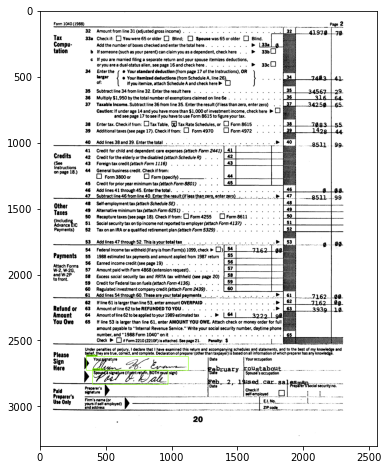

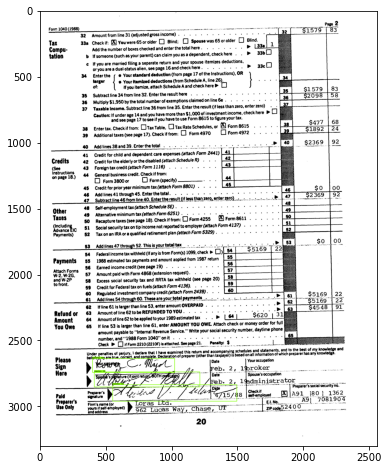

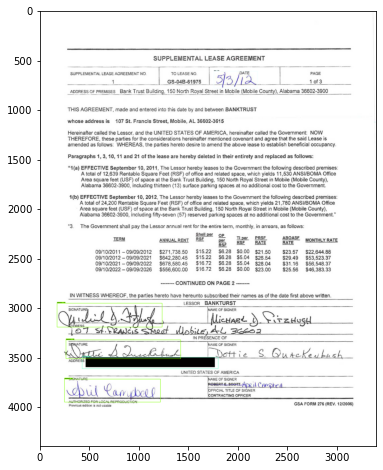

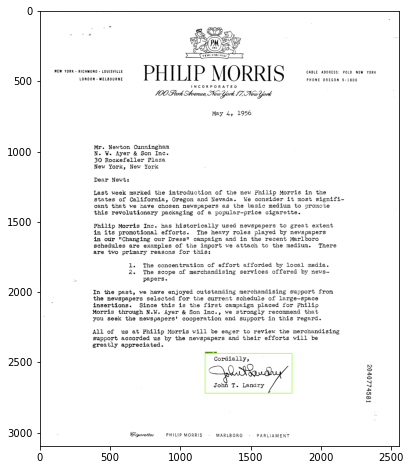

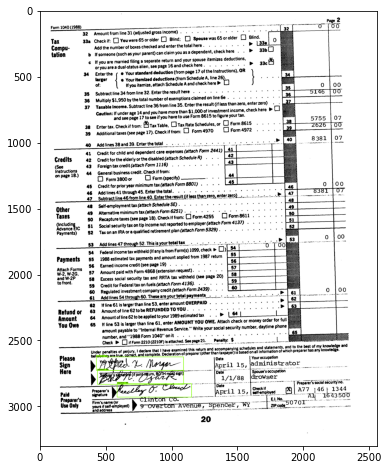

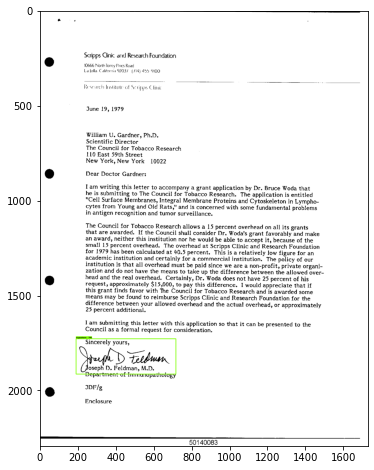

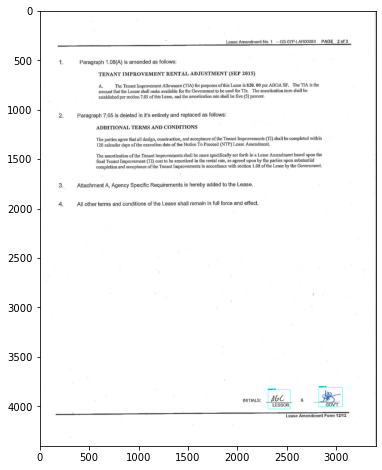

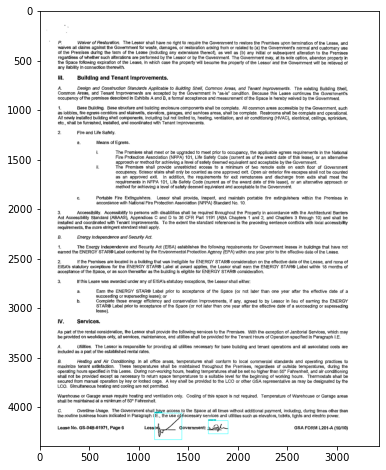

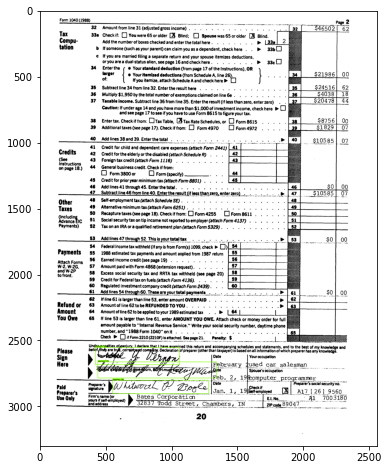

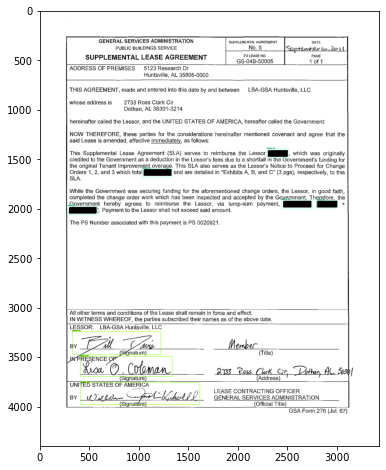

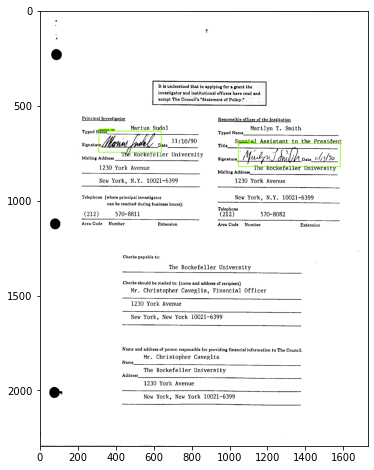

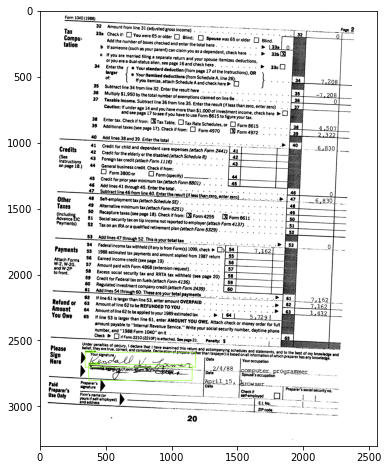

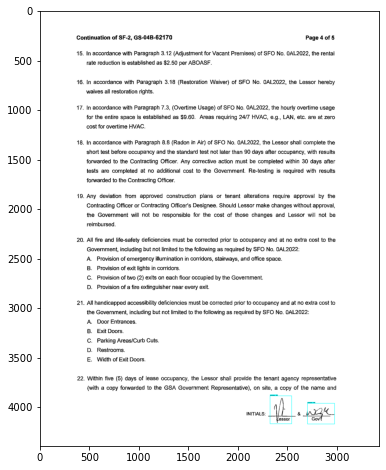

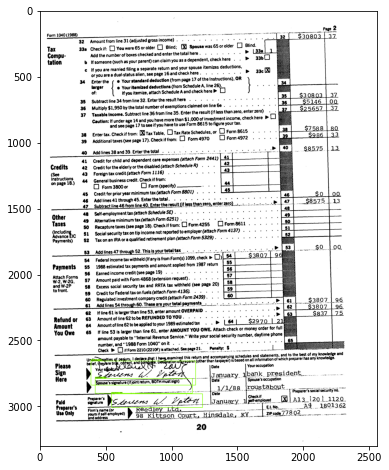

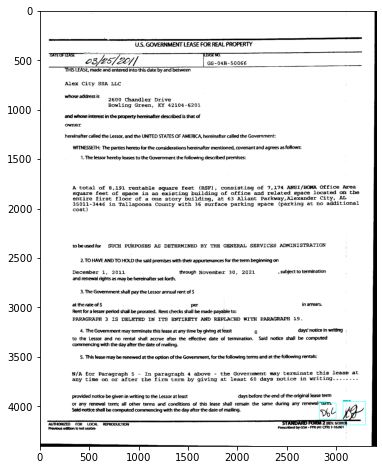

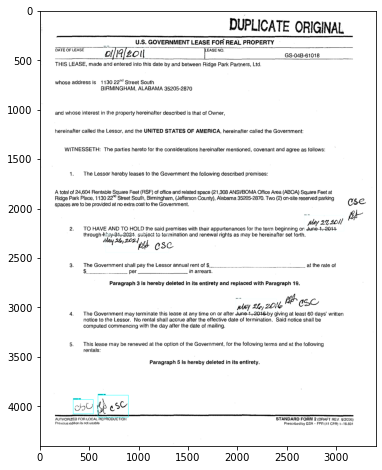

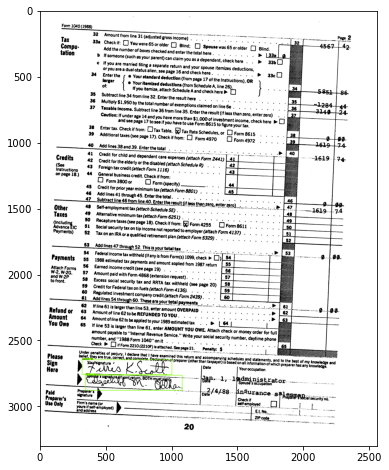

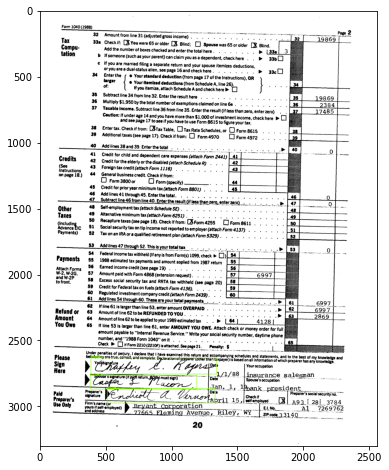

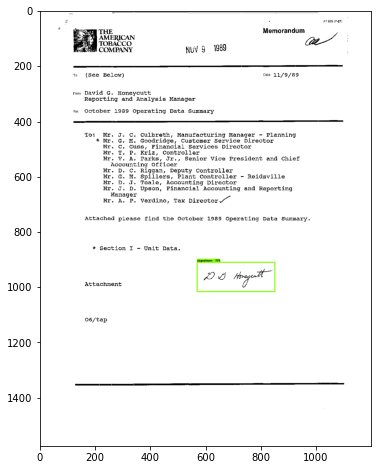

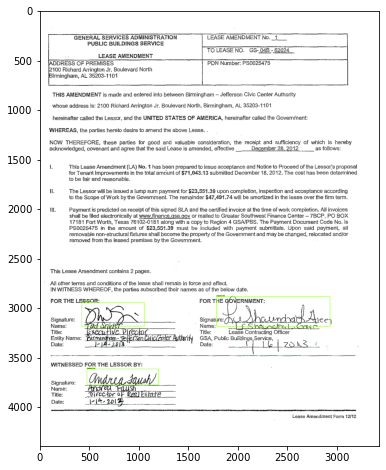

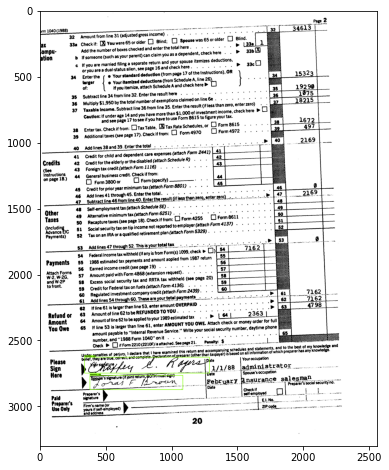

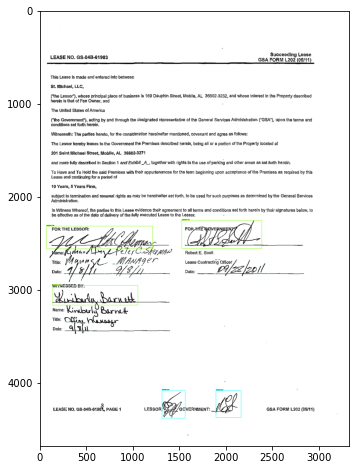

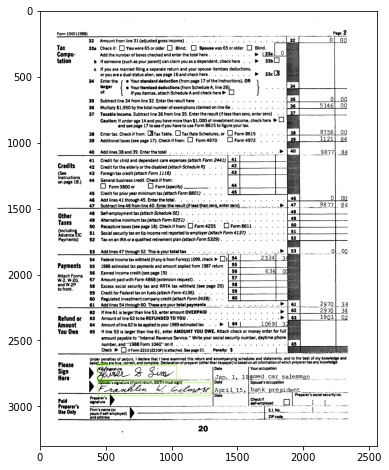

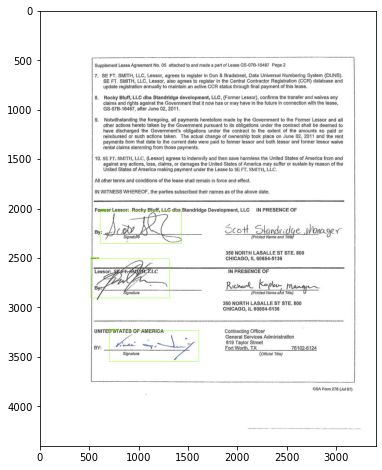

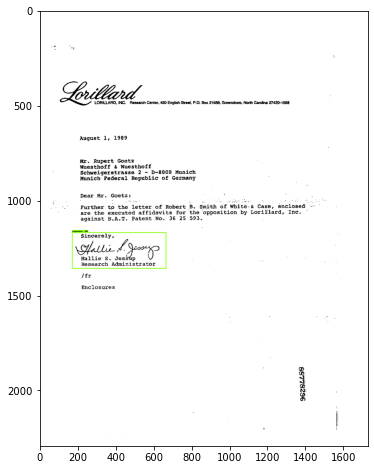

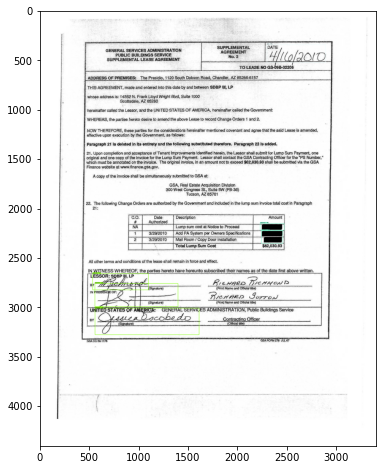

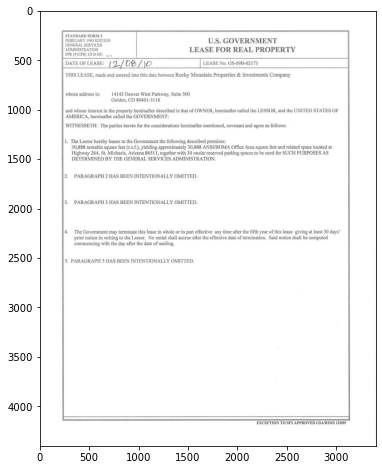

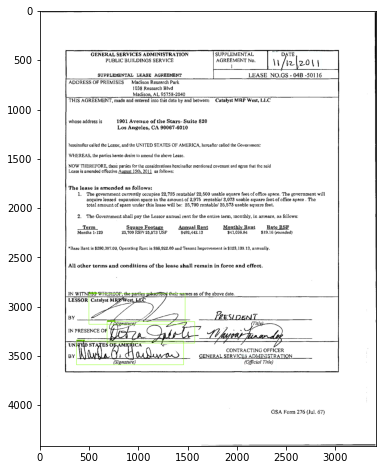

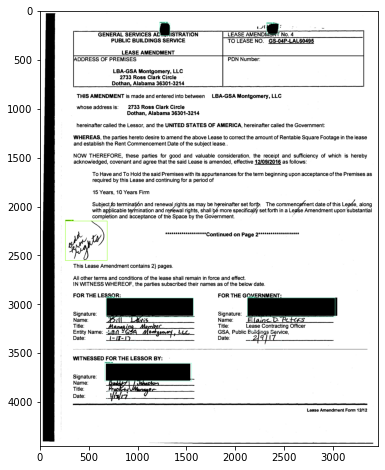

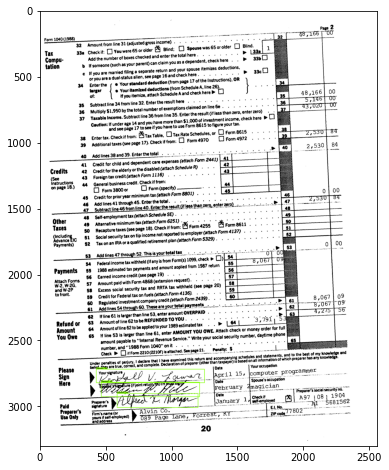

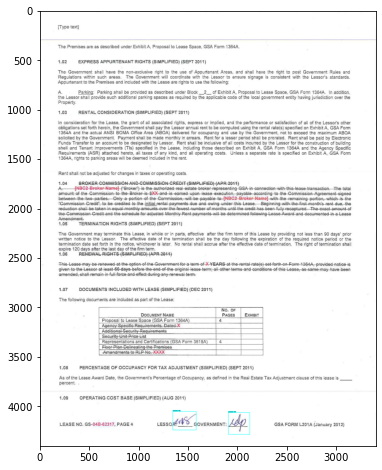

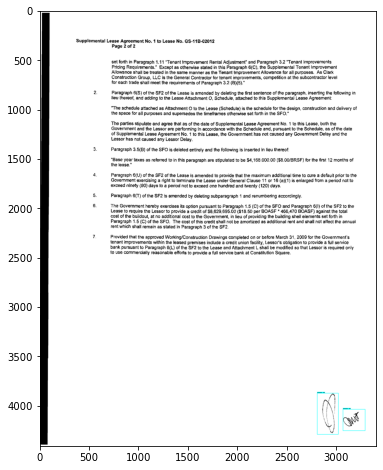

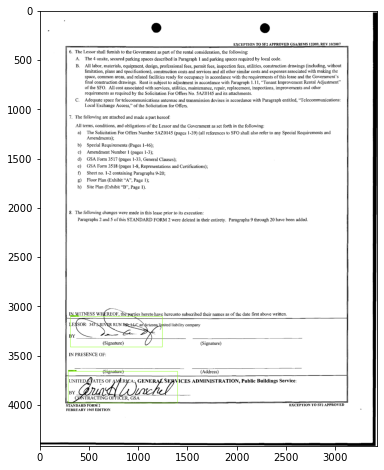

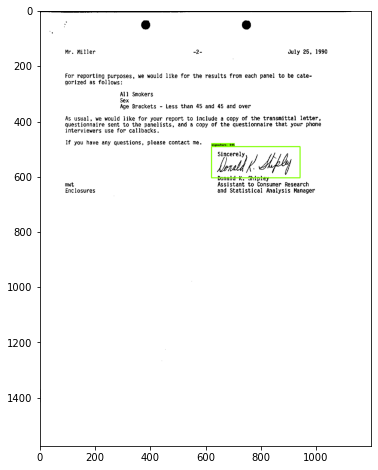

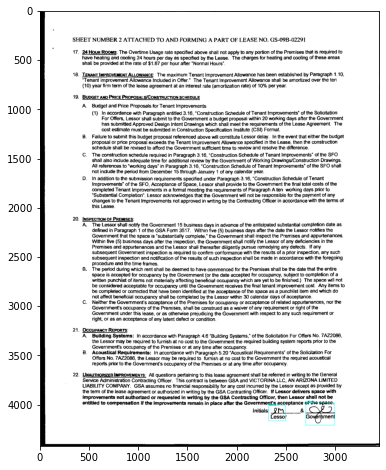

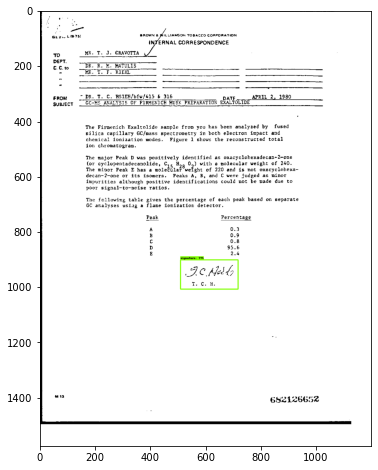

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
# This is required to display the images.
%matplotlib inline 

for image_path in IMAGE_PATHS_MIN:
    # if np.array(Image.open(image_path)).dtype!='bool':

    print('Running inference for {}... '.format(image_path), end='')
    im = (Image.open(image_path))
    im = im.convert("RGB")

        # Puts image into numpy array to feed into tensorflow graph.
        # Note that by convention we put it into a numpy array with shape
        #   (height, width, channels), where channels=3 for RGB.
    image_np = np.array(im)
        # print('dtype is' ,image_np.dtype)

        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
        # print(input_tensor)

        # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
        # print(input_tensor)

        # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                       for key, value in detections.items()}
    detections['num_detections'] = num_detections

        # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes'],
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=20,
              min_score_thresh=.30,
              agnostic_mode=False)

    plt.figure(figsize = (12,8))
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

In [ ]:
# import shutil
# shutil.make_archive('executable', 'zip', '/home/faizan_samad/testing')

In [ ]:
type((Image.open('/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0108_01.png')))

In [ ]:
image_path='/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/X_019.jpeg'
image_path2 = '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/hcu72e00_2.png'
image_path3= '/home/faizan_samad/doc_testing/Object-detection/driving-object-detection/Images/test/nist_r0108_01.png'
img = Image.open(image_path)
img = img.convert("RGB")
image_np = np.array(img)
        # print('dtype is' ,image_np.dtype)

        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
        # print(input_tensor)

        # The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

In [ ]:
image_np.shape

In [ ]:
import numpy as np
from PIL import Image
im = (Image.open(image_path))
Im = (Image.open(image_path2))
IMG = (Image.open(image_path3))

In [ ]:
im = im.convert("RGB")
print(im.format)
print(im.size)
print(im.mode)

In [ ]:
print(Im.format)
print(Im.size)
print(Im.mode)

In [ ]:
IMG = IMG.convert("RGB")
print(IMG.format)
print(IMG.size)
print(IMG.mode)

In [ ]:
im = (Image.open(image_path3))
im = im.convert("RGB")
image_np = np.array(im)
        # print('dtype is' ,image_np.dtype)

        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
        # print(input_tensor)

        # The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]
        # print(input_tensor)

        # input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                       for key, value in detections.items()}
detections['num_detections'] = num_detections

        # detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes'],
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=20,
              min_score_thresh=.30,
              agnostic_mode=False)

plt.figure(figsize = (12,8))
plt.imshow(image_np_with_detections)
print('Done')
plt.show()